In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [7]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [10]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [13]:
# Use inspect to see the preview of the table in the database 
inspector = inspect(engine)
tables = inspector.get_table_names()
print (f"The tables names in the database are {tables}")

The tables names in the database are ['measurement', 'station']


In [18]:
# Inspect the columns of the first table 
columns = inspector.get_columns(tables[0])
print("\nColumns in the table:")
for col in columns:
    print(f"{col['name']} - {col['type']}")


Columns in the table:
id - INTEGER
station - TEXT
date - TEXT
prcp - FLOAT
tobs - FLOAT


In [19]:
# Inspect the columns of the second table 
columns = inspector.get_columns(tables[1])
print("\nColumns in the table:")
for col in columns:
    print(f"{col['name']} - {col['type']}")


Columns in the table:
id - INTEGER
station - TEXT
name - TEXT
latitude - FLOAT
longitude - FLOAT
elevation - FLOAT


In [23]:
# Reflect an existing database into a new model
Base = automap_base()

# Reflect the tables
Base.prepare(engine, reflect=True)


/var/folders/rn/h0jsj52532jgpm4cc66mm4rm0000gn/T/ipykernel_287/3537866735.py:5: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [27]:
# Reflect the database using autoload_with instead of reflect to avoid the above warrning messages 
Base = automap_base()
Base.prepare(autoload_with=engine)

In [28]:
# View all of the classes that automap found
print(Base.classes.keys())

['station', 'measurement']


In [29]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [30]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [33]:
# Find the most recent date in the data set.
Most_Recent_Date = session.query(func.max(Measurement.date)).first()
Most_Recent_Date

('2017-08-23',)

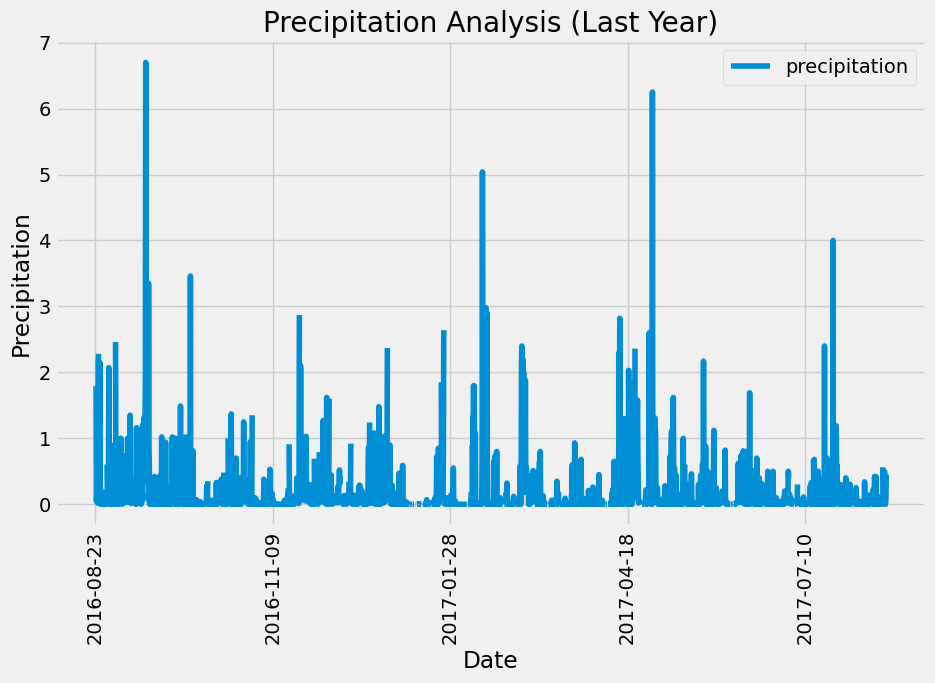

In [91]:
# Calculate the date one year from the last date in data set.
previous_year_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
data_preci_score = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= previous_year_date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
data_preci_scoreDF = pd.DataFrame(data_preci_score, columns=['date', 'precipitation'])

# Sort the dataframe by date
data_preci_scoreDF = data_preci_scoreDF.sort_values("date")
data_preci_scoreDF.head()

# Use Pandas Plotting with Matplotlib to plot the data
data_preci_scoreDF.plot(x='date', y='precipitation', figsize=(10, 6), rot=90)
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.title("Precipitation Analysis (Last Year)")
plt.savefig('Precipitation_analysis.png')
plt.show()

In [40]:
# Use Pandas to calculate the summary statistics for the precipitation data
data_preci_scoreDF.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [42]:
# Inspect the columns of the Station table to preview the proporties 
columns = inspector.get_columns(tables[1])
print("\nColumns in the table:")
for col in columns:
    print(f"{col['name']} - {col['type']}")


Columns in the table:
id - INTEGER
station - TEXT
name - TEXT
latitude - FLOAT
longitude - FLOAT
elevation - FLOAT


In [49]:
# Design a query to calculate the total number of stations in the dataset
# session.query(Station.station).count() -- if we want integer values representing the count of raws 
session.query(func.count(Station.station)).all()

[(9,)]

In [50]:
# Inspect the columns of the Measurment table to preview the proporties 
columns = inspector.get_columns(tables[1])
print("\nColumns in the table:")
for col in columns:
    print(f"{col['name']} - {col['type']}")


Columns in the table:
id - INTEGER
station - TEXT
name - TEXT
latitude - FLOAT
longitude - FLOAT
elevation - FLOAT


In [62]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
Active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
            group_by(Measurement.station).\
            order_by(func.count(Measurement.station).desc()).all()

# print the result using formating 
print("The most active stations in descending order:\n")
for station, count in Active_stations:
    print(f"Station ID: {station} | Count: {count}")

The most active stations in descending order:

Station ID: USC00519281 | Count: 2772
Station ID: USC00519397 | Count: 2724
Station ID: USC00513117 | Count: 2709
Station ID: USC00519523 | Count: 2669
Station ID: USC00516128 | Count: 2612
Station ID: USC00514830 | Count: 2202
Station ID: USC00511918 | Count: 1979
Station ID: USC00517948 | Count: 1372
Station ID: USC00518838 | Count: 511


In [71]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
Temp = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
                filter(Measurement.station == 'USC00519281').all()
print("The lowest, highest, and average temperature from the most active station are:\n")
for Min, Max, Ave in Temp:
        print(f"Minimun Temp: {Min},\nMaximum Temp: {Max},\nAverage Temp: {Ave}")

The lowest, highest, and average temperature from the most active station are:

Minimun Temp: 54.0,
Maximum Temp: 85.0,
Average Temp: 71.66378066378067


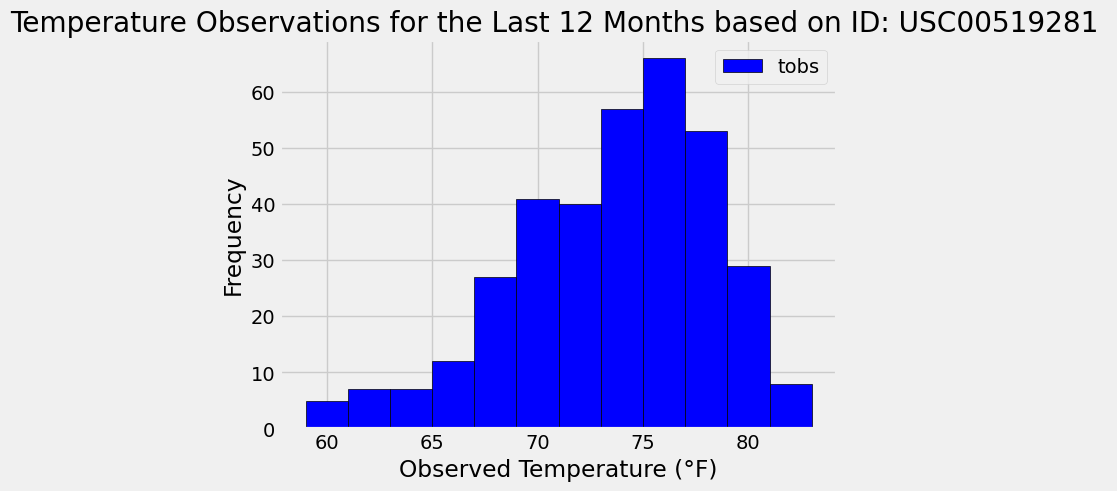

In [90]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
previous_year_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
Last12tobs = session.query(Measurement.tobs).\
                     filter(Measurement.station == 'USC00519281').\
                     filter(Measurement.date >= previous_year_date).all()

# Creating histogram
Last12tobsDF = pd.DataFrame(Last12tobs, columns=['tobs'])

Last12tobsDF.plot(kind='hist', bins=12, edgecolor='black', color='blue')

plt.xlabel('Observed Temperature (°F)')
plt.ylabel('Frequency')
plt.title('Temperature Observations for the Last 12 Months based on ID: USC00519281 ')
plt.savefig('temperature_histogram.png')
plt.show()

# Close Session

In [16]:
# Close Session
session.close()